### Desafío 1

##### **Configuración inicial**


In [2]:
%pip install numpy scikit-learn

import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB,ComplementNB
import numpy as np

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

##### **1**. Vectorizar documentos.

 Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.

In [22]:
tfidf = TfidfVectorizer()

# construir la matriz tf-idf calculando los valores de idf primero
X_train = tfidf.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target

In [6]:
np.random.seed(42)  # agrego una seed para poder reproducir nuevamente el experimento
random_indices = np.random.choice(X_train.shape[0], size=5, replace=False)
selected_docs = X_train[random_indices]
similarity_matrix = cosine_similarity(selected_docs, X_train)

In [7]:
# Función para obtener palabras clave más importantes del documento
def get_top_words(tfidf_matrix, index, feature_names, top_n=5):
    row = tfidf_matrix[index].toarray().flatten() # obtiene el vector de la matriz
    top_indices = row.argsort()[-top_n:][::-1] # lo ordena poniendo los términos más importantes al principio
    return feature_names[top_indices] # devuelve los primeros términos de la lista

feature_names = np.array(tfidf.get_feature_names_out())

for i, doc_idx in enumerate(random_indices):
    print(f"\n=== Documento {doc_idx} ({newsgroups_train.target_names[newsgroups_train.target[doc_idx]]}) ===")

    # Mostrar palabras clave del documento base
    top_words_base = get_top_words(X_train, doc_idx, feature_names)
    print(f"Palabras clave: {', '.join(top_words_base)}")

    most_similar_idx = np.argsort(similarity_matrix[i])[::-1][1:6]  # Excluir el mismo documento

    for idx in most_similar_idx:
        category = newsgroups_train.target_names[newsgroups_train.target[idx]]
        similarity_score = similarity_matrix[i, idx]

        # Mostrar palabras clave del documento similar
        top_words_similar = get_top_words(X_train, idx, feature_names)

        print(f"\n  - Documento {idx} ({category}) | Similitud: {similarity_score:.4f}")
        print(f"    Palabras clave: {', '.join(top_words_similar)}")

        if newsgroups_train.target[idx] == newsgroups_train.target[doc_idx]:
            print("    ✅ mismas categorias.")
        else:
            print("    ❌ distintas categorias.")


=== Documento 7492 (comp.sys.mac.hardware) ===
Palabras clave: rrn, novitskey, banging, cwru, pursuing

  - Documento 10935 (comp.sys.mac.hardware) | Similitud: 0.6665
    Palabras clave: rrn, cwru, po, want, areound
    ✅ mismas categorias.

  - Documento 7258 (comp.sys.ibm.pc.hardware) | Similitud: 0.3476
    Palabras clave: cwru, performance, cleve, 2134, p24t
    ❌ distintas categorias.

  - Documento 4971 (comp.sys.mac.hardware) | Similitud: 0.1799
    Palabras clave: vram, simms, jmk13, cwru, installing
    ✅ mismas categorias.

  - Documento 4303 (misc.forsale) | Similitud: 0.1547
    Palabras clave: gms2, sysex, cakewalk, roland, cwru
    ❌ distintas categorias.

  - Documento 645 (comp.sys.mac.hardware) | Similitud: 0.1414
    Palabras clave: info, 68040, specs, 68060, the
    ✅ mismas categorias.

=== Documento 3546 (comp.os.ms-windows.misc) ===
Palabras clave: cpbackup, fastback, cps, stripped, no

  - Documento 5665 (comp.sys.ibm.pc.hardware) | Similitud: 0.2040
    Palabr

Se puede observar que muchos documentos a pesar de tener baja similitud, comparten la categoría. Sin embargo, en el general de estos casos las categorías no coinciden.

Otro punto interesante para resaltar es que si bien las categorías no coinciden completamente algunas son muy similares. Por ejemplo _comp.sys.mac.hardware_ con _comp.sys.ibm.pc.hardware_ para el caso del primer documento y _talk.politics.misc_ con _talk.politics.guns_ para el cuarto

##### **2**. Entrenar modelos de clasificación Naïve Bayes

Maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

In [92]:
def fit_and_score(train, test, tfidf, clf, smote=None):
    X_train = tfidf.fit_transform(train.data)
    y_train = train.target

    X_test = tfidf.transform(test.data)
    y_test = test.target

    if smote is not None:
        X_train, y_train = smote.fit_resample(X_train, y_train)

    clf.fit(X_train, y_train)
    y_pred =  clf.predict(X_test)

    return f1_score(y_test, y_pred, average='macro')

Veamos el score con el caso base

In [93]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

print(fit_and_score(newsgroups_train, newsgroups_test, tfidf, clf))

0.5854345727938506


Ahora verificaremos si el dataset está homogéneamente distribuído en cada clase

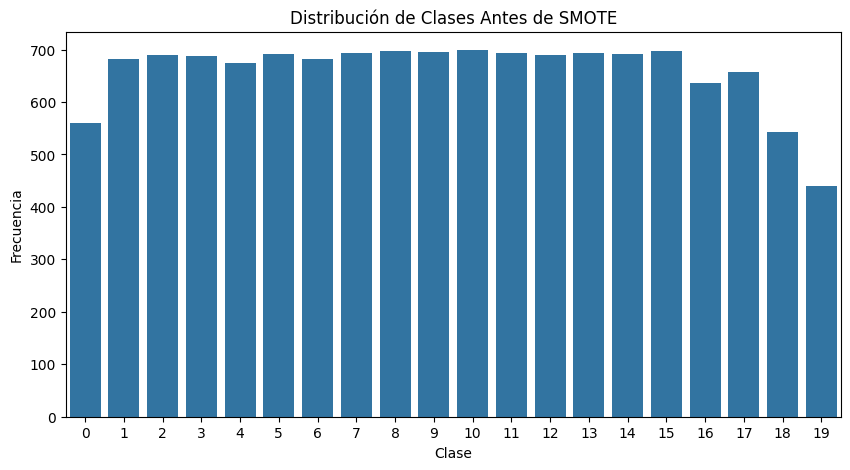

In [103]:
class_counts_before = Counter(y_train)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts_before.keys()), y=list(class_counts_before.values()))
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases Antes de SMOTE")
plt.show()

Se puede apreciar que si bien está distribuído todavía se podría mejorar

In [105]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()
smote = SMOTE(random_state=42)

print(fit_and_score(newsgroups_train, newsgroups_test, tfidf, clf, smote))

0.6177611942583028


Podemos apreciar un leve aumento del score, ahora haré diversas pruebas con los diversos parámetros del Vectorizer para encontrar los más óptimos

In [113]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)

tfidf_fn = lambda trial: fit_and_score(
    newsgroups_train,
    newsgroups_test,
    TfidfVectorizer(
        stop_words='english',
        max_df=trial.suggest_float("max_df", 0.8, 1, step=0.05),
        min_df=trial.suggest_int("min_df", 1, 5, step=1),
    ),
    MultinomialNB(alpha=trial.suggest_categorical("alpha", [0.1, 0.5, 1, 2, 5])),
    SMOTE(random_state=42)
)

study.optimize(tfidf_fn, n_trials=50)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  max_df: {trial.params['max_df']}")
    print(f"  min_df: {trial.params['min_df']}")
    print(f"  alpha: {trial.params['alpha']}")
    print(f"  Score: {trial.value}")

[I 2025-03-12 21:46:06,509] A new study created in memory with name: no-name-b7138e49-0dd7-4d0f-b333-fb2ea4343cfe
[I 2025-03-12 21:46:08,490] Trial 0 finished with value: 0.6753911831761203 and parameters: {'max_df': 1.0, 'min_df': 5, 'alpha': 1}. Best is trial 0 with value: 0.6753911831761203.
[I 2025-03-12 21:46:10,234] Trial 1 finished with value: 0.6520244678975282 and parameters: {'max_df': 0.8, 'min_df': 5, 'alpha': 5}. Best is trial 0 with value: 0.6753911831761203.
[I 2025-03-12 21:46:12,107] Trial 2 finished with value: 0.6471533150792819 and parameters: {'max_df': 0.8500000000000001, 'min_df': 1, 'alpha': 5}. Best is trial 0 with value: 0.6753911831761203.
[I 2025-03-12 21:46:13,878] Trial 3 finished with value: 0.6511384044843028 and parameters: {'max_df': 0.8, 'min_df': 2, 'alpha': 5}. Best is trial 0 with value: 0.6753911831761203.
[I 2025-03-12 21:46:15,607] Trial 4 finished with value: 0.6539463280073806 and parameters: {'max_df': 0.8500000000000001, 'min_df': 4, 'alpha'

Trial 0:
  max_df: 1.0
  min_df: 5
  alpha: 1
  Score: 0.6753911831761203
Trial 1:
  max_df: 0.8
  min_df: 5
  alpha: 5
  Score: 0.6520244678975282
Trial 2:
  max_df: 0.8500000000000001
  min_df: 1
  alpha: 5
  Score: 0.6471533150792819
Trial 3:
  max_df: 0.8
  min_df: 2
  alpha: 5
  Score: 0.6511384044843028
Trial 4:
  max_df: 0.8500000000000001
  min_df: 4
  alpha: 5
  Score: 0.6539463280073806
Trial 5:
  max_df: 0.9500000000000001
  min_df: 2
  alpha: 5
  Score: 0.6511384044843028
Trial 6:
  max_df: 1.0
  min_df: 1
  alpha: 5
  Score: 0.6471533150792819
Trial 7:
  max_df: 1.0
  min_df: 2
  alpha: 2
  Score: 0.6664425766065193
Trial 8:
  max_df: 0.9500000000000001
  min_df: 4
  alpha: 1
  Score: 0.6759307888502109
Trial 9:
  max_df: 1.0
  min_df: 1
  alpha: 2
  Score: 0.6646502534756035
Trial 10:
  max_df: 0.9
  min_df: 4
  alpha: 1
  Score: 0.6759307888502109
Trial 11:
  max_df: 0.9
  min_df: 4
  alpha: 1
  Score: 0.6759307888502109
Trial 12:
  max_df: 0.9
  min_df: 4
  alpha: 1
  S

La mejor configuración que encontré usando Optuna fue:

max_df: 0.9500000000000001
min_df: 2
alpha: 0.1
Score: 0.6918852292493343

Es decir, que excluirá los términos presentes en más del 95% de los documentos (max_df) y usará solo palabras que aparezcan al menos en 2 documentos (min_df). Lo primero es útil para evitar términos comunes en casi todos los documentos y el segundo para filtrar palabras extrañas.

Un parámetro muy útil es stop_words que permite eliminar palabras usuales en el idioma que no ayudan en nada a la hora de clasificar y solo generan ruido

El valor alpha controla la importancia que el algorítmo le dará a las palabras poco frecuentes, cuanto menor sea este valor mayor riesgo de sobreajuste tendremos pero encontraremos las palabras que fundamentales para cada cateogoría.

In [119]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)

tfidf_fn = lambda trial: fit_and_score(
    newsgroups_train,
    newsgroups_test,
    TfidfVectorizer(
        stop_words='english',
        max_df=trial.suggest_float("max_df", 0.6, 1, step=0.05),
        min_df=trial.suggest_int("min_df", 1, 5, step=1),
    ),
    ComplementNB(alpha=trial.suggest_categorical("alpha", [0.1, 0.5, 1, 2, 5])),
    SMOTE(random_state=42)
)

study.optimize(tfidf_fn, n_trials=50)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  max_df: {trial.params['max_df']}")
    print(f"  min_df: {trial.params['min_df']}")
    print(f"  alpha: {trial.params['alpha']}")
    print(f"  Score: {trial.value}")

[I 2025-03-12 22:09:29,562] A new study created in memory with name: no-name-dd389001-7b89-4ac5-b8b1-cbc4b2c8db1a
[I 2025-03-12 22:09:31,586] Trial 0 finished with value: 0.6867082885844416 and parameters: {'max_df': 1.0, 'min_df': 3, 'alpha': 5}. Best is trial 0 with value: 0.6867082885844416.
[I 2025-03-12 22:09:33,390] Trial 1 finished with value: 0.6922764905140186 and parameters: {'max_df': 0.7, 'min_df': 3, 'alpha': 2}. Best is trial 1 with value: 0.6922764905140186.
[I 2025-03-12 22:09:35,124] Trial 2 finished with value: 0.6925539906441165 and parameters: {'max_df': 0.9, 'min_df': 4, 'alpha': 1}. Best is trial 2 with value: 0.6925539906441165.
[I 2025-03-12 22:09:36,846] Trial 3 finished with value: 0.6866271523040907 and parameters: {'max_df': 0.85, 'min_df': 5, 'alpha': 0.5}. Best is trial 2 with value: 0.6925539906441165.
[I 2025-03-12 22:09:38,750] Trial 4 finished with value: 0.7027197156031733 and parameters: {'max_df': 0.95, 'min_df': 1, 'alpha': 0.5}. Best is trial 4 wi

Trial 0:
  max_df: 1.0
  min_df: 3
  alpha: 5
  Score: 0.6867082885844416
Trial 1:
  max_df: 0.7
  min_df: 3
  alpha: 2
  Score: 0.6922764905140186
Trial 2:
  max_df: 0.9
  min_df: 4
  alpha: 1
  Score: 0.6925539906441165
Trial 3:
  max_df: 0.85
  min_df: 5
  alpha: 0.5
  Score: 0.6866271523040907
Trial 4:
  max_df: 0.95
  min_df: 1
  alpha: 0.5
  Score: 0.7027197156031733
Trial 5:
  max_df: 0.6
  min_df: 4
  alpha: 0.5
  Score: 0.6912508087516207
Trial 6:
  max_df: 0.85
  min_df: 1
  alpha: 1
  Score: 0.7015822634281295
Trial 7:
  max_df: 0.85
  min_df: 5
  alpha: 1
  Score: 0.6866459701293897
Trial 8:
  max_df: 0.9
  min_df: 4
  alpha: 2
  Score: 0.6915987435222009
Trial 9:
  max_df: 0.9
  min_df: 5
  alpha: 0.1
  Score: 0.6777358665300441
Trial 10:
  max_df: 1.0
  min_df: 1
  alpha: 0.5
  Score: 0.7027197156031733
Trial 11:
  max_df: 1.0
  min_df: 1
  alpha: 0.5
  Score: 0.7027197156031733
Trial 12:
  max_df: 1.0
  min_df: 2
  alpha: 0.5
  Score: 0.6991995243335223
Trial 13:
  max_d

La configuración con mejores resultados fue:
max_df: 0.95
min_df: 1
alpha: 0.5
Score: 0.7027197156031733

Es de esperarse que los resultados no sean mucho mejores que MultinomialNB, ya que se hizo una normalización de la frecuencia de las clases. Se realizó un experimento evitando normalizar los datos, pero usando ComplementNB y los resultados fueron muy similares a los anteriores (~0.69). Comprobándose así que este clasificador es especialmente bueno cuando la data no está bien distribuída.

##### **3**. Transponer la matriz documento-término.

De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras. Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.

In [10]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=1,
)

X_train = tfidf.fit_transform(newsgroups_train.data)
X_train_t = X_train.T

words = np.array(tfidf.get_feature_names_out())

La elección de cada palabra se hizo en base a las palabras claves del apartado 1.

In [15]:
def most_similar(word, top_n=5):
    word_idx = np.where(words == word)[0][0]
    word_vector = X_train_t[word_idx]
    sim_scores = cosine_similarity(word_vector, X_train_t).flatten()
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]

    return [(words[i], sim_scores[i]) for i in top_indices]

selected_words = ["god", "performance", "tape", "guns", "language"]

for word in selected_words:
    print(f"Palabras más similares a '{word}':")
    print(most_similar(word))
    print()

Palabras más similares a 'god':
[('jesus', np.float64(0.2806262905501705)), ('bible', np.float64(0.2763907900798565)), ('christ', np.float64(0.2668302503858808)), ('faith', np.float64(0.259282392330588)), ('existence', np.float64(0.25887388594680283))]

Palabras más similares a 'performance':
[('wintach', np.float64(0.22285238449144668)), ('drumroll', np.float64(0.215285674027661)), ('disparity', np.float64(0.21436744350224693)), ('ranges', np.float64(0.19702000929316393)), ('rvenkate', np.float64(0.17948803285299328))]

Palabras más similares a 'tape':
[('tapes', np.float64(0.3431222641083042)), ('unwound', np.float64(0.30611565366171256)), ('alighment', np.float64(0.30611565366171256)), ('whiles', np.float64(0.30611565366171256)), ('hiles', np.float64(0.30611565366171256))]

Palabras más similares a 'guns':
[('gun', np.float64(0.3773993944368909)), ('preyed', np.float64(0.27255087893397856)), ('statistisk', np.float64(0.24449629396869219)), ('axer', np.float64(0.24449629396869219)), 

Se pueden ver claras similitudes como el plural o el singular de la palabra elegida (caso de gun y tape), y el hecho de que sean las palabras más similares es un indicio que el vectorizador está haciendo un buen trabajo.

Otros casos son bastante intersantes como la similitud que encuentra entre guns y oppinion.